In [5]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the verbal dataset
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'   # Update this to your file path
verbal_data = pd.read_excel(verbal_data_path)

# Prepare input and target texts from the verbal dataset
input_texts = verbal_data['Word'].astype(str).tolist()
target_texts = verbal_data['Base Word'].astype(str).tolist()

# Define parameters for the Seq2Seq model
max_len_input = max([len(text) for text in input_texts])
max_len_target = max([len(text) for text in target_texts])
num_samples = len(input_texts)

# Tokenize input and target sequences
tokenizer_inputs = Tokenizer(char_level=True)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

tokenizer_outputs = Tokenizer(char_level=True)
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# Pad sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Create target data, which is the decoder target shifted by one timestep
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Build the Seq2Seq model
latent_dim = 256  # Size of LSTM units

# Encoder
encoder_inputs = Input(shape=(None,))  # Variable-length sequence input
encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=64)(encoder_inputs)  # Embedding for input sequences
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=64)(decoder_inputs)  # Embedding for target sequences
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Compile the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize model structure
model.summary()

# Model is now ready to train with the verbal dataset


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 64)  │      2,432 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 64)  │      2,304 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    328,704 │ embedding_1[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    328,704 │ embedding_2[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 36)  │      9,252 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 671,396 (2.56 MB)

 Trainable params: 671,396 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
batch_size = 64
epochs = 50

history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.0839 - loss: 1.3299 - val_accuracy: 0.1133 - val_loss: 1.1231
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.0733 - loss: 1.2181 - val_accuracy: 0.0694 - val_loss: 1.1023
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.0735 - loss: 1.2232 - val_accuracy: 0.0694 - val_loss: 1.1215
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.0762 - loss: 1.2287 - val_accuracy: 0.0694 - val_loss: 1.1258
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.0732 - loss: 1.2077 - val_accuracy: 0.0694 - val_loss: 1.1205
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.0700 - loss: 1.2135 - val_accuracy: 0.0694 - val_loss: 1.1183
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.0737 - loss: 1.2231 - val_accuracy: 0.0694 - val_loss: 1.1298
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.0728 - loss: 1.2209 - val_accuracy: 0.

In [7]:
model.save('verbal_seq2seq_model.h5')

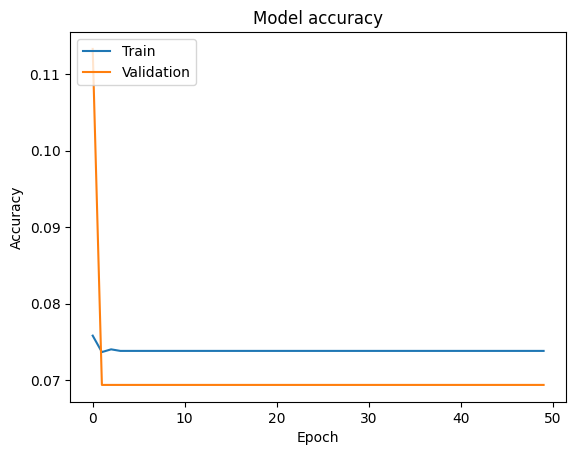

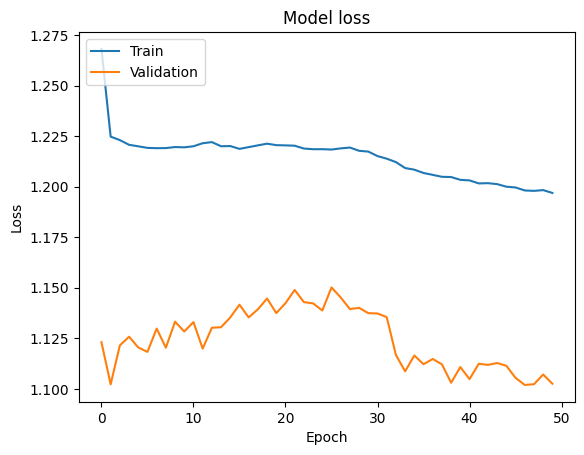

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0677 - loss: 1.3545 - val_accuracy: 0.0694 - val_loss: 1.2000
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0731 - loss: 1.2611 - val_accuracy: 0.0694 - val_loss: 1.1845
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0711 - loss: 1.2797 - val_accuracy: 0.0694 - val_loss: 1.1865
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0756 - loss: 1.2693 - val_accuracy: 0.0694 - val_loss: 1.1906
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0727 - loss: 1.2800 - val_accuracy: 0.0694 - val_loss: 1.1846
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0742 - loss: 1.2625 - val_accuracy: 0.0694 - val_loss: 1.1897
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0739 - loss: 1.2631 - val_accuracy: 0.0694 - val_loss: 1.1816
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0751 - loss: 1.2771 - val_accuracy: 0.0694 - val_loss

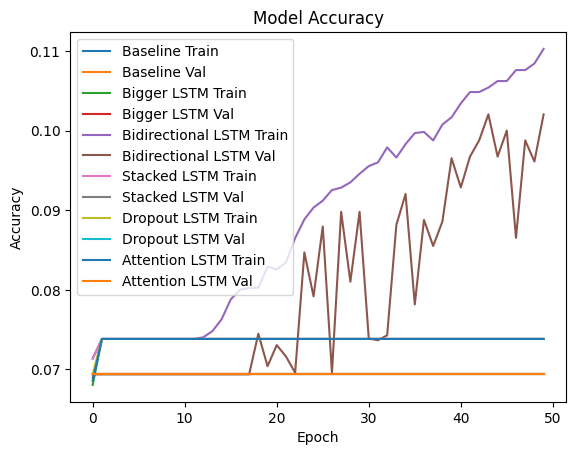

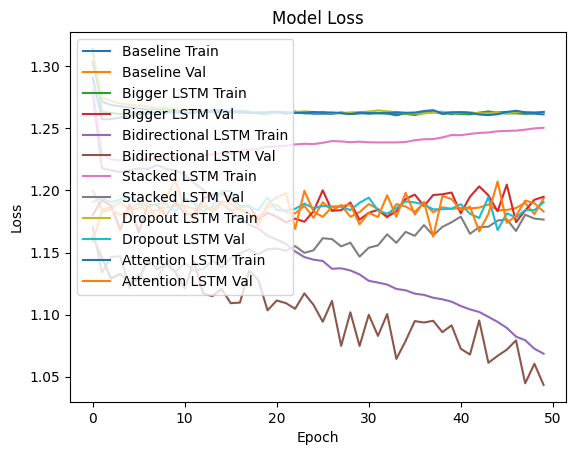

In [2]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout, Concatenate, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Load the verbal dataset
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'  # Update this to your file path
verbal_data = pd.read_excel(verbal_data_path)

# Prepare input and target texts from the verbal dataset
input_texts = verbal_data['Word'].astype(str).tolist()
target_texts = verbal_data['Base Word'].astype(str).tolist()

# Tokenize input and target sequences
tokenizer_inputs = Tokenizer(char_level=True)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

tokenizer_outputs = Tokenizer(char_level=True)
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# Pad sequences
max_len_input = max([len(text) for text in input_texts])
max_len_target = max([len(text) for text in target_texts])
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Create target data
num_samples = len(input_texts)
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Function to build and train models
def build_and_train_model(model_name, encoder_lstm, decoder_lstm, callbacks=None, batch_size=64, epochs=50):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=64)(encoder_inputs)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=64)(decoder_inputs)
    decoder_lstm_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    
    # Apply Dense to only the decoder output (which is the sequence of predictions)
    decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm_outputs)

    # Compile and train the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=callbacks
    )
    # Save the model and history
    model.save(f'{model_name}.h5')
    return history

# Different LSTM and model configurations
def baseline_model():
    lstm = LSTM(256, return_state=True, return_sequences=True)
    return build_and_train_model("baseline_seq2seq", lstm, lstm)

def bigger_lstm_model():
    lstm = LSTM(512, return_state=True, return_sequences=True)
    return build_and_train_model("bigger_lstm_seq2seq", lstm, lstm)

def bidirectional_model():
    # Define the bidirectional LSTM
    lstm = Bidirectional(LSTM(256, return_state=True, return_sequences=True))
    
    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=64)(encoder_inputs)
    
    # Since bidirectional LSTM returns more states, we need to handle it differently
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = lstm(encoder_embedding)
    
    # Concatenate the forward and backward hidden and cell states
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=64)(decoder_inputs)
    decoder_lstm_outputs, _, _ = LSTM(512, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    
    # Dense layer for decoder output
    decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm_outputs)
    
    # Compile and train the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=50, validation_split=0.2)
    
    model.save("bidirectional_lstm_seq2seq.h5")
    
    return history


def stacked_lstm_model():
    lstm1 = LSTM(256, return_sequences=True, return_state=True)
    lstm2 = LSTM(256, return_state=True, return_sequences=True)
    return build_and_train_model("stacked_lstm_seq2seq", lstm1, lstm2)

def dropout_model():
    lstm = LSTM(256, return_state=True, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    return build_and_train_model("dropout_lstm_seq2seq", lstm, lstm)

def attention_model():
    lstm = LSTM(256, return_sequences=True, return_state=True)
    # Define attention mechanism
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=64)(encoder_inputs)
    encoder_outputs, state_h, state_c = lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=64)(decoder_inputs)
    decoder_lstm_outputs, _, _ = lstm(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_lstm_outputs, encoder_outputs])
    decoder_concat_input = Concatenate(axis=-1)([decoder_lstm_outputs, attention])
    decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
    decoder_outputs = decoder_dense(decoder_concat_input)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=50, validation_split=0.2)
    model.save("attention_lstm_seq2seq.h5")
    return history

# Train all models
histories = {
    "Baseline": baseline_model(),
    "Bigger LSTM": bigger_lstm_model(),
    "Bidirectional LSTM": bidirectional_model(),
    "Stacked LSTM": stacked_lstm_model(),
    "Dropout LSTM": dropout_model(),
    "Attention LSTM": attention_model()
}

# Plotting results
def plot_history(histories):
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Train')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Call plot function
plot_history(histories)


In [3]:
import pandas as pd

# Function to collect accuracy and loss from the training histories
def collect_metrics(histories):
    metrics = []
    for model_name, history in histories.items():
        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        metrics.append({
            "Model": model_name,
            "Training Accuracy": train_accuracy,
            "Validation Accuracy": val_accuracy,
            "Training Loss": train_loss,
            "Validation Loss": val_loss
        })
    
    # Create a DataFrame for better readability
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# Collect the metrics and display them in a table
metrics_df = collect_metrics(histories)

# Display the metrics table
metrics_df


,Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,Baseline,0.07383,0.069388,1.261263,1.193551
1,Bigger LSTM,0.07383,0.069388,1.263253,1.194849
2,Bidirectional LSTM,0.11026,0.102041,1.068492,1.043345
3,Stacked LSTM,0.07383,0.069388,1.250479,1.176547
4,Dropout LSTM,0.07383,0.069388,1.262823,1.190544
5,Attention LSTM,0.07383,0.069388,1.263179,1.182967


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.0615 - loss: 1.3667 - val_accuracy: 0.0694 - val_loss: 1.2054 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.0742 - loss: 1.2787 - val_accuracy: 0.0694 - val_loss: 1.2066 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0780 - loss: 1.2783 - val_accuracy: 0.0694 - val_loss: 1.2037 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0745 - loss: 1.2712 - val_accuracy: 0.0694 - val_loss: 1.2028 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0722 - loss: 1.2586 - val_accuracy: 0.0694 - val_loss: 1.1999 - learning_rate: 0.0010
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0752 - loss: 1.2871 - val_accuracy: 0.0694 - val_loss: 1.1882 - learning_rate: 0.0010
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0741 - loss: 1.2839 - val_acc

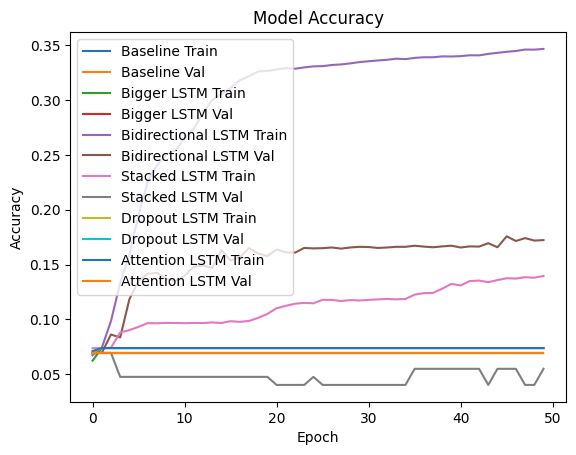

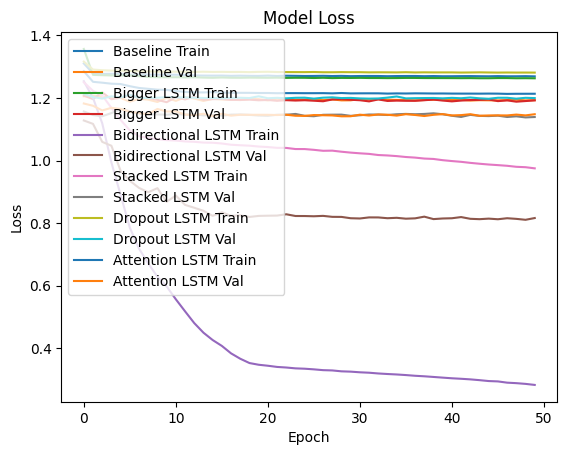

,Model,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,Baseline,0.073830,0.069388,1.269006,1.192988
1,Bigger LSTM,0.073830,0.069388,1.262877,1.192309
2,Bidirectional LSTM,0.346567,0.172245,0.282602,0.816109
3,Stacked LSTM,0.139587,0.054898,0.974972,1.139090
4,Dropout LSTM,0.073830,0.069388,1.281098,1.199564
5,Attention LSTM,0.073830,0.069388,1.213460,1.147997


In [6]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dropout, Concatenate, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load the verbal dataset
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'  # Update this to your file path
verbal_data = pd.read_excel(verbal_data_path)

# Prepare input and target texts from the verbal dataset
input_texts = verbal_data['Word'].astype(str).tolist()
target_texts = verbal_data['Base Word'].astype(str).tolist()

# Tokenize input and target sequences
tokenizer_inputs = Tokenizer(char_level=True)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

tokenizer_outputs = Tokenizer(char_level=True)
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# Pad sequences
max_len_input = max([len(text) for text in input_texts])
max_len_target = max([len(text) for text in target_texts])
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Create target data
num_samples = len(input_texts)
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Function to build and train models
def build_and_train_model(model_name, encoder_lstm, decoder_lstm, callbacks=[reduce_lr], batch_size=64, epochs=50):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=128)(encoder_inputs)  # Increased embedding size
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=128)(decoder_inputs)  # Increased embedding size
    decoder_lstm_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    
    # Apply Dense to only the decoder output (which is the sequence of predictions)
    decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm_outputs)

    # Compile and train the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  # Using Adam optimizer
    history = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=callbacks
    )
    # Save the model and history
    model.save(f'{model_name}.h5')
    return history

# Different LSTM and model configurations
def baseline_model():
    lstm = LSTM(512, return_state=True, return_sequences=True, dropout=0.3)  # Increased LSTM units and added dropout
    return build_and_train_model("baseline_seq2seq", lstm, lstm)

def bigger_lstm_model():
    lstm = LSTM(1024, return_state=True, return_sequences=True, dropout=0.3)  # Larger LSTM units
    return build_and_train_model("bigger_lstm_seq2seq", lstm, lstm)

def bidirectional_model():
    # Define the bidirectional LSTM
    lstm = Bidirectional(LSTM(512, return_state=True, return_sequences=True, dropout=0.3))
    
    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=128)(encoder_inputs)
    
    # Since bidirectional LSTM returns more states, we need to handle it differently
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = lstm(encoder_embedding)
    
    # Concatenate the forward and backward hidden and cell states
    state_h = Concatenate()([forward_h, backward_h])  # Size is now 1024
    state_c = Concatenate()([forward_c, backward_c])  # Size is now 1024
    
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=128)(decoder_inputs)
    # Now we use 1024 units in the decoder LSTM to match the encoder states
    decoder_lstm_outputs, _, _ = LSTM(1024, return_sequences=True, return_state=True, dropout=0.3)(decoder_embedding, initial_state=encoder_states)
    
    # Dense layer for decoder output
    decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm_outputs)
    
    # Compile and train the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=50, validation_split=0.2, callbacks=[reduce_lr])
    
    model.save("bidirectional_lstm_seq2seq.h5")
    
    return history


def stacked_lstm_model():
    lstm1 = LSTM(512, return_sequences=True, return_state=True, dropout=0.3)
    lstm2 = LSTM(512, return_state=True, return_sequences=True, dropout=0.3)
    return build_and_train_model("stacked_lstm_seq2seq", lstm1, lstm2)

def dropout_model():
    lstm = LSTM(512, return_state=True, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    return build_and_train_model("dropout_lstm_seq2seq", lstm, lstm)

def attention_model():
    lstm = LSTM(512, return_sequences=True, return_state=True, dropout=0.3)
    # Define attention mechanism
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=len(tokenizer_inputs.word_index) + 1, output_dim=128)(encoder_inputs)
    encoder_outputs, state_h, state_c = lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=len(tokenizer_outputs.word_index) + 1, output_dim=128)(decoder_inputs)
    decoder_lstm_outputs, _, _ = lstm(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_lstm_outputs, encoder_outputs])
    decoder_concat_input = Concatenate(axis=-1)([decoder_lstm_outputs, attention])
    decoder_dense = Dense(len(tokenizer_outputs.word_index) + 1, activation='softmax')
    decoder_outputs = decoder_dense(decoder_concat_input)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=50, validation_split=0.2, callbacks=[reduce_lr])
    model.save("attention_lstm_seq2seq.h5")
    return history

# Train all models
histories = {
    "Baseline": baseline_model(),
    "Bigger LSTM": bigger_lstm_model(),
    "Bidirectional LSTM": bidirectional_model(),
    "Stacked LSTM": stacked_lstm_model(),
    "Dropout LSTM": dropout_model(),
    "Attention LSTM": attention_model()
}

# Plotting results
def plot_history(histories):
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{model_name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    for model_name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{model_name} Train')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

# Call plot function
plot_history(histories)

# Function to collect accuracy and loss from the training histories
def collect_metrics(histories):
    metrics = []
    for model_name, history in histories.items():
        train_accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        
        metrics.append({
            "Model": model_name,
            "Training Accuracy": train_accuracy,
            "Validation Accuracy": val_accuracy,
            "Training Loss": train_loss,
            "Validation Loss": val_loss
        })
    
    # Create a DataFrame for better readability
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# Collect the metrics and display them in a table
metrics_df = collect_metrics(histories)

# Display the metrics table
metrics_df



        Word Base Word
0    bhavasi      bhav
1  bhavathaḥ      bhav
2   bhavatha      bhav
3    bhavāmi      bhav
4   bhavāvaḥ      bhav
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0717 - loss: 1.3055 - val_accuracy: 0.0694 - val_loss: 1.1388 - learning_rate: 5.0000e-04
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0737 - loss: 1.2218 - val_accuracy: 0.0694 - val_loss: 1.1436 - learning_rate: 5.0000e-04
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0774 - loss: 1.2161 - val_accuracy: 0.0694 - val_loss: 1.1313 - learning_rate: 5.0000e-04
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0745 - loss: 1.1967 - val_accuracy: 0.0694 - val_loss: 1.1434 - learning_rate: 5.0000e-04
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0827 - loss: 1.1689 - val_accuracy: 0.0694 - val_loss: 1.1431 - learning_rate: 5.0000e-04
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0859 - loss: 1.1259 - val_a

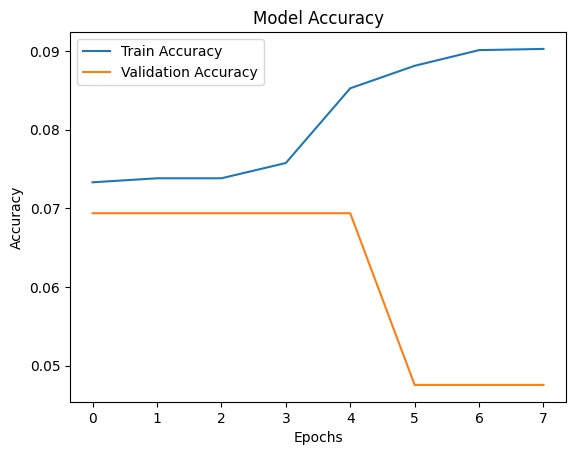

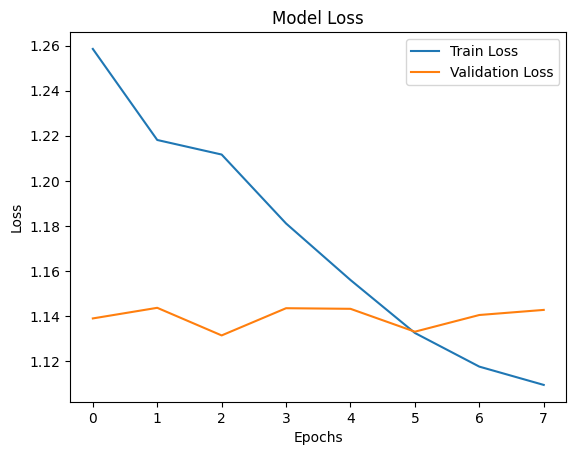

Final Training Accuracy: 0.09028203040361404
Final Validation Accuracy: 0.047551024705171585
Final Training Loss: 1.1092939376831055
Final Validation Loss: 1.142627239227295


In [7]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load the dataset
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'  # Update this to your file path
verbal_data = pd.read_excel(verbal_data_path)

# Inspect data
print(verbal_data.head())

# Prepare input and target texts from the dataset
input_texts = verbal_data['Word'].astype(str).tolist()
target_texts = verbal_data['Base Word'].astype(str).tolist()

# Tokenize input and target sequences
tokenizer_inputs = Tokenizer(char_level=True)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

tokenizer_outputs = Tokenizer(char_level=True)
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# Padding the sequences
max_len_input = max([len(text) for text in input_texts])
max_len_target = max([len(text) for text in target_texts])
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Create target data with one-hot encoding
num_samples = len(input_texts)
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Early stopping and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Define a very simple sanity check model
def simple_sanity_check_model():
    latent_dim = 256  # Small latent dimension
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, 64)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 64)(decoder_inputs)
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build and train the simple model
model = simple_sanity_check_model()
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# Output the results
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

# Evaluate the model with training and validation accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")


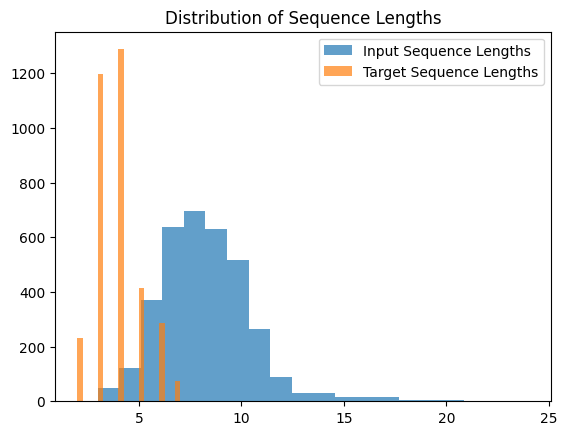

Number of unique base words (target): 200
Examples of input-target pairs:
               Word Base Word
2665        kūrdeta      kūrd
2304  bhakṣayiṣyati   bhakṣay
682       atanumahi       tan
1303    vrajiṣyāvaḥ      vraj
1929      maṅkṣyasi      maṅk


In [8]:
# Analyze the distribution of input and target sequence lengths
input_lengths = [len(seq) for seq in input_texts]
target_lengths = [len(seq) for seq in target_texts]

import matplotlib.pyplot as plt

plt.hist(input_lengths, bins=20, alpha=0.7, label='Input Sequence Lengths')
plt.hist(target_lengths, bins=20, alpha=0.7, label='Target Sequence Lengths')
plt.legend(loc='upper right')
plt.title("Distribution of Sequence Lengths")
plt.show()

# Check unique base words (targets)
unique_targets = verbal_data['Base Word'].nunique()
print(f"Number of unique base words (target): {unique_targets}")

# Display a few examples
print(f"Examples of input-target pairs:\n{verbal_data.sample(5)}")


In [9]:
def ultra_simple_sanity_check_model():
    latent_dim = 128  # Reduce the latent dimension even further
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, 32)(encoder_inputs)  # Smaller embedding size
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 32)(decoder_inputs)  # Smaller embedding size
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Train the ultra-simple model
model = ultra_simple_sanity_check_model()
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=30,  # Reducing the number of epochs to prevent overfitting early
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0564 - loss: 1.4245 - val_accuracy: 0.0694 - val_loss: 1.2004 - learning_rate: 2.0000e-04
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0754 - loss: 1.2653 - val_accuracy: 0.0694 - val_loss: 1.1870 - learning_rate: 2.0000e-04
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0740 - loss: 1.2467 - val_accuracy: 0.0694 - val_loss: 1.1651 - learning_rate: 2.0000e-04
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0773 - loss: 1.2597 - val_accuracy: 0.0694 - val_loss: 1.1703 - learning_rate: 2.0000e-04
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0741 - loss: 1.2570 - val_accuracy: 0.0694 - val_loss: 1.1696 - learning_rate: 2.0000e-04


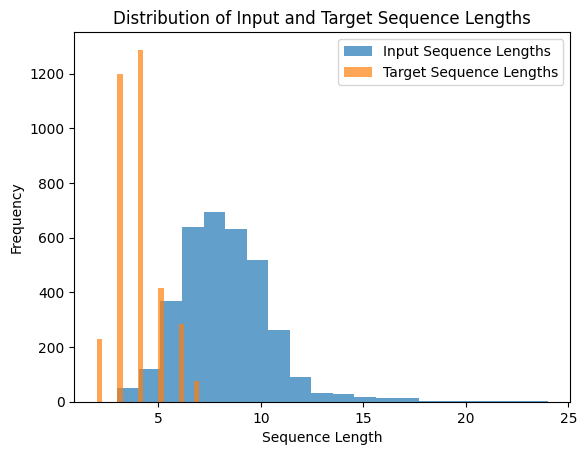

Max input sequence length: 24
Max target sequence length: 7
Average input sequence length: 8.501144164759726
Average target sequence length: 3.872711670480549


In [10]:
# Analyze the distribution of input and target sequence lengths
input_lengths = [len(seq) for seq in input_texts]
target_lengths = [len(seq) for seq in target_texts]

import matplotlib.pyplot as plt

# Plot histograms for input and target sequence lengths
plt.hist(input_lengths, bins=20, alpha=0.7, label='Input Sequence Lengths')
plt.hist(target_lengths, bins=20, alpha=0.7, label='Target Sequence Lengths')
plt.legend(loc='upper right')
plt.title("Distribution of Input and Target Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

# Summary statistics
print(f"Max input sequence length: {max(input_lengths)}")
print(f"Max target sequence length: {max(target_lengths)}")
print(f"Average input sequence length: {sum(input_lengths)/len(input_lengths)}")
print(f"Average target sequence length: {sum(target_lengths)/len(target_lengths)}")


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0671 - loss: 1.4614 - val_accuracy: 0.0694 - val_loss: 1.1507 - learning_rate: 2.0000e-04
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0736 - loss: 1.2507 - val_accuracy: 0.0694 - val_loss: 1.1397 - learning_rate: 2.0000e-04
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0755 - loss: 1.2380 - val_accuracy: 0.0694 - val_loss: 1.1387 - learning_rate: 2.0000e-04
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0753 - loss: 1.2233 - val_accuracy: 0.0694 - val_loss: 1.1281 - learning_rate: 2.0000e-04
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0749 - loss: 1.2330 - val_accuracy: 0.0696 - val_loss: 1.1163 - learning_rate: 2.0000e-04
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0791 - loss: 1.2004 - val_accuracy: 0.0739 - val_loss: 1.1122 - learning_rate: 2.0000e-04
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0862 - loss

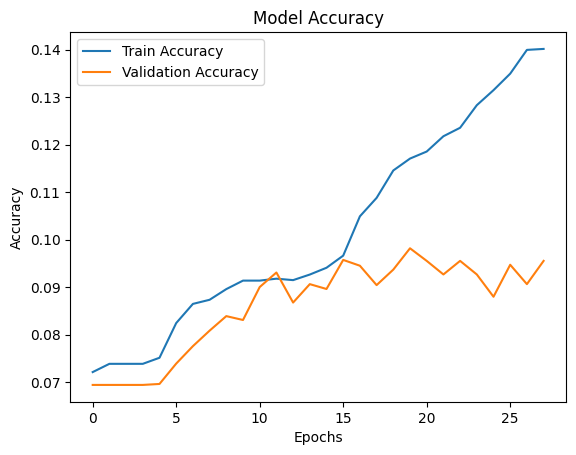

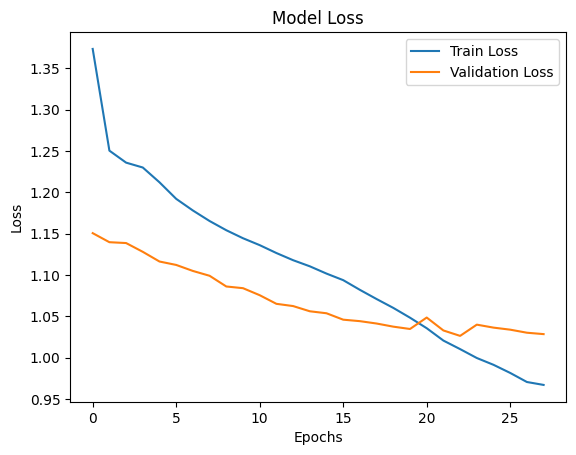

Final Training Accuracy: 0.14014914631843567
Final Validation Accuracy: 0.09551020711660385
Final Training Loss: 0.966981053352356
Final Validation Loss: 1.028472900390625


In [11]:
# Trim input sequences to a maximum of 15 characters for simplicity
max_len_input = 15
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')

# Keep target sequences as is
max_len_target = 7
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Update the decoder target data accordingly
num_samples = len(input_texts)
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Rebuild the model
def smaller_sanity_check_model():
    latent_dim = 128  # Keep the latent dimension small
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, 32)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 32)(decoder_inputs)
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Train the smaller model
model = smaller_sanity_check_model()
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# Plot the results
plot_training_history(history)

# Final evaluation
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0592 - loss: 0.0404 - val_accuracy: 0.0694 - val_loss: 0.0318 - learning_rate: 2.0000e-04
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0768 - loss: 0.0340 - val_accuracy: 0.0841 - val_loss: 0.0306 - learning_rate: 2.0000e-04
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0820 - loss: 0.0320 - val_accuracy: 0.0920 - val_loss: 0.0307 - learning_rate: 2.0000e-04
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1112 - loss: 0.0301 - val_accuracy: 0.0873 - val_loss: 0.0301 - learning_rate: 2.0000e-04
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1379 - loss: 0.0280 - val_accuracy: 0.0896 - val_loss: 0.0298 - learning_rate: 2.0000e-04
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1644 - loss: 0.0255 - val_accuracy: 0.0943 - val_loss: 0.0281 - learning_rate: 2.0000e-04
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1787 - loss

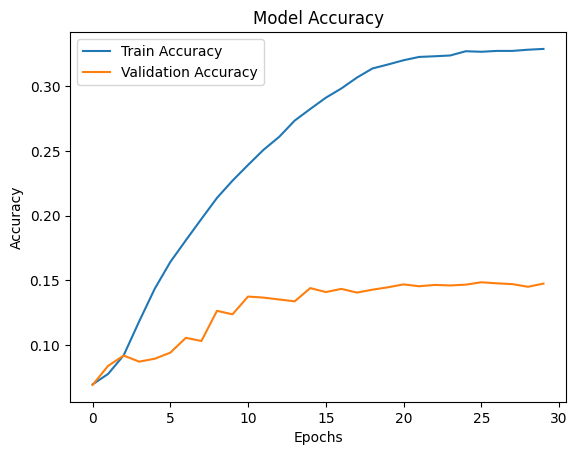

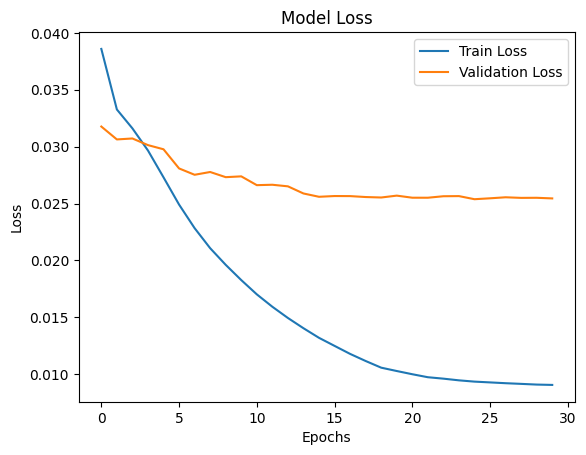

In [15]:
import numpy as np
from tensorflow.keras import backend as K

# Convert the base word counts to a proper weights array
base_word_counts = verbal_data['Base Word'].value_counts()
total_counts = sum(base_word_counts)
class_weights = np.zeros(len(tokenizer_outputs.word_index) + 1, dtype='float32')  # Ensure float32

for base_word, count in base_word_counts.items():
    idx = tokenizer_outputs.word_index.get(base_word, None)
    if idx is not None and count > 0:
        class_weights[idx] = total_counts / count

# Avoid division by zero by setting very small values to weights
class_weights[class_weights == 0] = 1e-6

# Normalize weights
class_weights /= class_weights.sum()

# Custom weighted loss function with correct data types
def custom_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # y_true is one-hot encoded; need to calculate the class index first
        y_true_class = K.argmax(y_true, axis=-1)
        
        # Look up the class weights based on the true class
        weights = K.gather(class_weights, y_true_class)
        
        # Apply weights to the standard categorical crossentropy loss
        unweighted_loss = K.categorical_crossentropy(y_true, y_pred)
        weighted_loss = unweighted_loss * K.cast(weights, 'float32')  # Ensure both are float32
        return K.mean(weighted_loss, axis=-1)
    return loss

# Rebuild the model with the custom weighted loss
def model_with_weighted_loss():
    latent_dim = 128
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, 32)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 32)(decoder_inputs)
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model with custom weighted loss
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss=custom_categorical_crossentropy(class_weights), metrics=['accuracy'])

    return model

# Train with the weighted loss model
model = model_with_weighted_loss()
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# Plot the results
plot_training_history(history)


In [18]:
import pandas as pd

# Function to collect accuracy and loss from the training history
def collect_metrics(history):
    metrics = {
        "Training Accuracy": history.history['accuracy'][-1],
        "Validation Accuracy": history.history['val_accuracy'][-1],
        "Training Loss": history.history['loss'][-1],
        "Validation Loss": history.history['val_loss'][-1]
    }
    return metrics

# After training, collect metrics and create a table
metrics = collect_metrics(history)

# Create a DataFrame for better readability
metrics_df = pd.DataFrame([metrics])

# Display the accuracy and loss metrics table
print(metrics_df)


   Training Accuracy  Validation Accuracy  Training Loss  Validation Loss
0           0.328582             0.147551        0.00907         0.025453


Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2912 - loss: 0.0125 - val_accuracy: 0.2475 - val_loss: 0.0161 - learning_rate: 1.2500e-05
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2845 - loss: 0.0120 - val_accuracy: 0.2492 - val_loss: 0.0159 - learning_rate: 1.2500e-05
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2917 - loss: 0.0119 - val_accuracy: 0.2498 - val_loss: 0.0158 - learning_rate: 1.2500e-05
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2930 - loss: 0.0117 - val_accuracy: 0.2498 - val_loss: 0.0157 - learning_rate: 1.2500e-05
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2927 - loss: 0.0116 - val_accuracy: 0.2506 - val_loss: 0.0156 - learning_rate: 1.2500e-05
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2925 - loss: 0.0114 - val_accuracy: 0.2506 - val_loss: 0.0155 - learning_rate: 1.2500e-05
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 

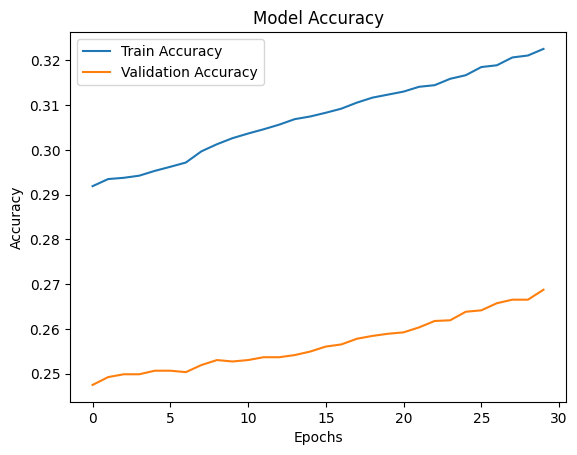

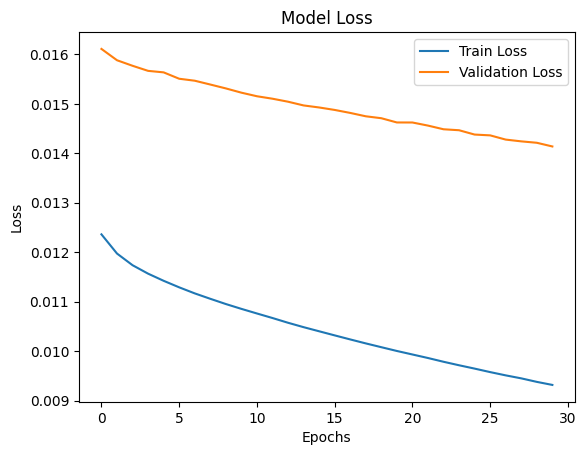

In [21]:
# Function to introduce perturbations in input sequences
def augment_sequence(sequence, tokenizer_inputs, augment_factor=0.3):
    sequence = list(sequence)  # Turn the sequence into a list of characters
    num_perturbations = int(augment_factor * len(sequence))  # Number of perturbations based on sequence length

    for _ in range(num_perturbations):
        # Choose a random perturbation: insert, delete, or substitute
        perturb_type = random.choice(['insert', 'delete', 'substitute'])

        if perturb_type == 'insert':
            # Insert a random character at a random position
            insert_char = random.choice(list(tokenizer_inputs.word_index.keys()))
            insert_pos = random.randint(0, len(sequence))
            sequence.insert(insert_pos, insert_char)

        elif perturb_type == 'delete' and len(sequence) > 1:
            # Delete a character at a random position
            delete_pos = random.randint(0, len(sequence) - 1)
            sequence.pop(delete_pos)

        elif perturb_type == 'substitute':
            # Substitute a random character with another character
            substitute_pos = random.randint(0, len(sequence) - 1)
            substitute_char = random.choice(list(tokenizer_inputs.word_index.keys()))
            sequence[substitute_pos] = substitute_char

    return ''.join(sequence)

# Augment the input and target dataset together
def augment_data(input_texts, target_texts, tokenizer_inputs, augment_factor=0.3, num_augmented=1000):
    augmented_input_texts = []
    augmented_target_texts = []
    
    for _ in range(num_augmented):
        # Randomly pick an input sequence and its corresponding target
        idx = random.randint(0, len(input_texts) - 1)
        original_input_sequence = input_texts[idx]
        original_target_sequence = target_texts[idx]
        
        # Augment the input sequence
        augmented_input_sequence = augment_sequence(original_input_sequence, tokenizer_inputs, augment_factor)
        
        # Add the augmented input and its original target to the lists
        augmented_input_texts.append(augmented_input_sequence)
        augmented_target_texts.append(original_target_sequence)

    return augmented_input_texts, augmented_target_texts

# Augment 1000 new samples with random perturbations
augmented_input_texts, augmented_target_texts = augment_data(input_texts, target_texts, tokenizer_inputs, augment_factor=0.3, num_augmented=1000)

# Add augmented data to the original input and target texts and re-tokenize
input_texts_augmented = input_texts + augmented_input_texts
target_texts_augmented = target_texts + augmented_target_texts

# Tokenize and pad augmented input sequences
input_sequences_augmented = tokenizer_inputs.texts_to_sequences(input_texts_augmented)
encoder_input_data_augmented = pad_sequences(input_sequences_augmented, maxlen=max_len_input, padding='post')

# Tokenize and pad augmented target sequences
target_sequences_augmented = tokenizer_outputs.texts_to_sequences(target_texts_augmented)
decoder_input_data_augmented = pad_sequences(target_sequences_augmented, maxlen=max_len_target, padding='post')

# Update decoder target data for augmented sequences
decoder_target_data_augmented = np.zeros((len(target_texts_augmented), max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences_augmented):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data_augmented[i, t - 1, char] = 1.0

# Train the model on augmented data
history_augmented = model.fit(
    [encoder_input_data_augmented, decoder_input_data_augmented],
    decoder_target_data_augmented,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# Plot the augmented training results
plot_training_history(history_augmented)


In [20]:
from gensim.models import FastText

# Load pre-trained FastText embeddings (assuming you have the FastText model file)
fasttext_model = FastText.load('/path_to_fasttext_model/fasttext_model.bin')

# Build the embedding matrix using the tokenizer
embedding_dim = 300  # FastText uses 300-dimensional embeddings
vocab_size = len(tokenizer_inputs.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer_inputs.word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)  # Random vectors for unknown words

# Modify the model to use pre-trained embeddings
def model_with_fasttext_embeddings():
    latent_dim = 128
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    # Encoder with FastText embeddings
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model with pre-trained embeddings
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Train the model with FastText embeddings
model_fasttext = model_with_fasttext_embeddings()
history_fasttext = model_fasttext.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# Plot the FastText results
plot_training_history(history_fasttext)


FileNotFoundError: [Errno 2] No such file or directory: '/path_to_fasttext_model/fasttext_model.bin'

#GPT approch and lstm


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0681 - loss: 1.1933 - val_accuracy: 0.0522 - val_loss: 0.8826
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0745 - loss: 1.1150 - val_accuracy: 0.0522 - val_loss: 0.8879
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0761 - loss: 1.1243 - val_accuracy: 0.0522 - val_loss: 0.8755
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0719 - loss: 1.1125 - val_accuracy: 0.0522 - val_loss: 0.8732
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0746 - loss: 1.1134 - val_accuracy: 0.0522 - val_loss: 0.8665
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0740 - loss: 1.1210 - val_accuracy: 0.0522 - val_loss: 0.8698
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0732 - loss: 1.1104 - val_accuracy: 0.0522 - val_loss: 0.8726
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0726 - loss: 1.1081 - val_accuracy: 0.0522 - val_loss

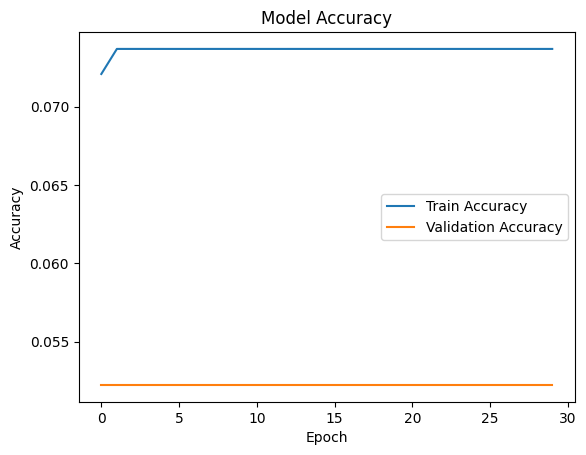

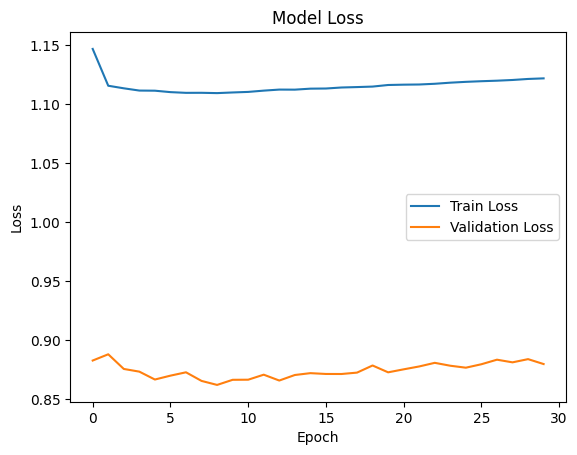

,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,0.073679,0.052249,1.121933,0.879611


In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load the provided noun and verbal datasets
nouns_data_path = '/Concordance_project-main/Nouns_new_7.xlsx'
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'

nouns_data = pd.read_excel(nouns_data_path)
verbal_data = pd.read_excel(verbal_data_path)

# Combine the nouns and verbal datasets for training
combined_data = pd.concat([nouns_data, verbal_data], axis=0)

# Prepare input and target texts
input_texts = combined_data['Word'].astype(str).tolist()
target_texts = combined_data['Base Word'].astype(str).tolist()

# Tokenize input and target sequences
tokenizer_inputs = Tokenizer(char_level=True)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

tokenizer_outputs = Tokenizer(char_level=True)
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# Padding the sequences
max_len_input = max([len(text) for text in input_texts])
max_len_target = max([len(text) for text in target_texts])
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Create target data with one-hot encoding
num_samples = len(input_texts)
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Function to build and train the LSTM Seq2Seq model
def build_lstm_seq2seq_model():
    latent_dim = 256  # Size of LSTM hidden layers
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, 64)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 64)(decoder_inputs)
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the LSTM Seq2Seq model
lstm_model = build_lstm_seq2seq_model()

# Train the model
history = lstm_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=30,
    validation_split=0.2
)

# Plot training results
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

# Function to collect accuracy and loss from the history
def collect_metrics(history):
    metrics = {
        "Training Accuracy": history.history['accuracy'][-1],
        "Validation Accuracy": history.history['val_accuracy'][-1],
        "Training Loss": history.history['loss'][-1],
        "Validation Loss": history.history['val_loss'][-1]
    }
    return metrics

# Collect and display metrics in a table
metrics = collect_metrics(history)
metrics_df = pd.DataFrame([metrics])
metrics_df


Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.1122 - loss: 1.2547 - val_accuracy: 0.0522 - val_loss: 0.8784
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0766 - loss: 1.1212 - val_accuracy: 0.0522 - val_loss: 0.8796
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0734 - loss: 1.1154 - val_accuracy: 0.0522 - val_loss: 0.8752
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0735 - loss: 1.1141 - val_accuracy: 0.0522 - val_loss: 0.8723
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0746 - loss: 1.1177 - val_accuracy: 0.0522 - val_loss: 0.8740
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0726 - loss: 1.1177 - val_accuracy: 0.0522 - val_loss: 0.8720
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0747 - loss: 1.1221 - val_accuracy: 0.0522 - val_loss: 0.8772
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0736 - loss: 1.1123 - val_accuracy: 0.0522 - v

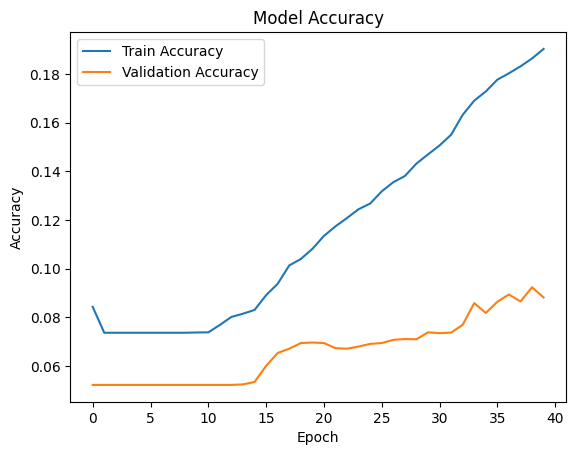

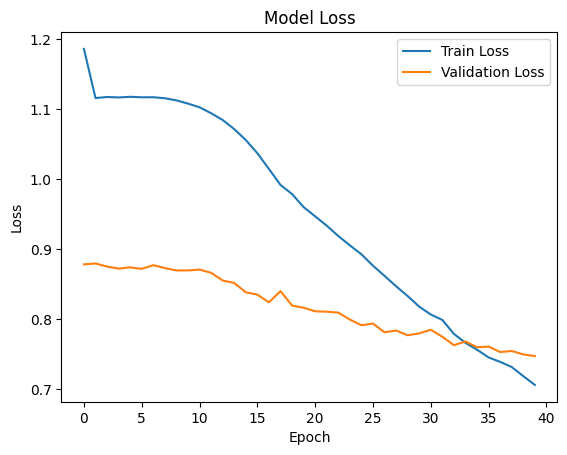

,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,0.190275,0.088183,0.706343,0.747501


In [23]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Load the provided noun and verbal datasets
nouns_data_path = '/Concordance_project-main/Nouns_new_7.xlsx'
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'

nouns_data = pd.read_excel(nouns_data_path)
verbal_data = pd.read_excel(verbal_data_path)

# Combine the nouns and verbal datasets for training
combined_data = pd.concat([nouns_data, verbal_data], axis=0)

# Prepare input and target texts
input_texts = combined_data['Word'].astype(str).tolist()
target_texts = combined_data['Base Word'].astype(str).tolist()

# Tokenize input and target sequences
tokenizer_inputs = Tokenizer(char_level=True)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

tokenizer_outputs = Tokenizer(char_level=True)
tokenizer_outputs.fit_on_texts(target_texts)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)

# Padding the sequences
max_len_input = max([len(text) for text in input_texts])
max_len_target = max([len(text) for text in target_texts])
encoder_input_data = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

# Create target data with one-hot encoding
num_samples = len(input_texts)
decoder_target_data = np.zeros((num_samples, max_len_target, len(tokenizer_outputs.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, char in enumerate(seq):
        if t > 0:
            decoder_target_data[i, t - 1, char] = 1.0

# Function to build and train the enhanced LSTM Seq2Seq model
def build_enhanced_lstm_seq2seq_model():
    latent_dim = 512  # Increased size of LSTM hidden layers
    input_vocab_size = len(tokenizer_inputs.word_index) + 1
    output_vocab_size = len(tokenizer_outputs.word_index) + 1

    # Encoder
    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_vocab_size, 128)(encoder_inputs)  # Increased embedding size
    encoder_lstm1, state_h1, state_c1 = LSTM(latent_dim, return_state=True, return_sequences=True)(encoder_embedding)
    encoder_lstm2, state_h2, state_c2 = LSTM(latent_dim, return_state=True)(encoder_lstm1)  # Added another LSTM layer
    encoder_states = [state_h2, state_c2]

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(output_vocab_size, 128)(decoder_inputs)  # Increased embedding size
    decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Compile the model with Adam optimizer and reduced learning rate
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the enhanced LSTM Seq2Seq model
enhanced_lstm_model = build_enhanced_lstm_seq2seq_model()

# Train the model
history = enhanced_lstm_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=64,
    epochs=40,  # Increased epochs for more training
    validation_split=0.2
)

# Plot training results
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

# Function to collect accuracy and loss from the history
def collect_metrics(history):
    metrics = {
        "Training Accuracy": history.history['accuracy'][-1],
        "Validation Accuracy": history.history['val_accuracy'][-1],
        "Training Loss": history.history['loss'][-1],
        "Validation Loss": history.history['val_loss'][-1]
    }
    return metrics

# Collect and display metrics in a table
metrics = collect_metrics(history)
metrics_df = pd.DataFrame([metrics])
metrics_df


In [24]:
import pandas as pd
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
import torch

# Load the datasets (nouns and verbal)
nouns_data_path = '/Concordance_project-main/Nouns_new_7.xlsx'
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'

nouns_data = pd.read_excel(nouns_data_path)
verbal_data = pd.read_excel(verbal_data_path)

# Combine the noun and verbal datasets
combined_data = pd.concat([nouns_data, verbal_data], axis=0)

# Prepare the data for GPT-2 by combining words and base forms into input-output pairs
combined_data['input_output'] = combined_data['Word'] + " -> " + combined_data['Base Word']

# Convert to Hugging Face Dataset format
dataset = Dataset.from_pandas(combined_data[['input_output']])

# Initialize GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set the pad token to eos_token to avoid padding issues
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['input_output'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,  # We are doing causal language modeling, not masked language modeling
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-base-word-output",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Increase if needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,  # Default learning rate
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()

# Print metrics
print(metrics)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/5039 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 1315, in forward
    transformer_outputs = self.transformer(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 1129, in forward
    outputs = block(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 614, in forward
    attn_outputs = self.attn(
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py", line 559, in forward
    attn_output = self.resid_dropout(attn_output)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/dropout.py", line 59, in forward
    return F.dropout(input, self.p, self.training, self.inplace)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py", line 1295, in dropout
    return _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 16.12 MiB is free. Process 2858 has 14.72 GiB memory in use. Of the allocated memory 864.32 MiB is allocated by PyTorch, and 57.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [28]:
import pandas as pd
from datasets import Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
import torch

# Disable W&B logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Load the datasets (nouns and verbal)
nouns_data_path = '/Concordance_project-main/Nouns_new_7.xlsx'
verbal_data_path = '/Concordance_project-main/verbal_new2.xlsx'

nouns_data = pd.read_excel(nouns_data_path)
verbal_data = pd.read_excel(verbal_data_path)

# Combine the noun and verbal datasets
combined_data = pd.concat([nouns_data, verbal_data], axis=0)

# Prepare the data for GPT-2 by combining words and base forms into input-output pairs
combined_data['input_output'] = combined_data['Word'] + " -> " + combined_data['Base Word']

# Convert to Hugging Face Dataset format
dataset = Dataset.from_pandas(combined_data[['input_output']])

# Initialize GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set the pad token to eos_token to avoid padding issues
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['input_output'], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,  # We are doing causal language modeling, not masked language modeling
)

# Training arguments with reduced batch size, gradient accumulation, and mixed precision training
training_args = TrainingArguments(
    output_dir="./gpt2-base-word-output",
    overwrite_output_dir=True,
    num_train_epochs=3,  # You can increase this if needed
    per_device_train_batch_size=2,  # Reduced batch size
    per_device_eval_batch_size=2,  # Reduced eval batch size
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    gradient_accumulation_steps=8,  # Accumulate gradients over 8 steps to simulate a larger batch size
    fp16=True,  # Use mixed precision training
    report_to="none",  # Disable W&B logging
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()

# Print metrics
print(metrics)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/5039 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 20.12 MiB is free. Process 2858 has 14.72 GiB memory in use. Of the allocated memory 853.56 MiB is allocated by PyTorch, and 64.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)